In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from sklearn.metrics import r2_score
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

SYMBOL = "BTC-USD"
END_DATE = (datetime.date.today() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
date_range_1 = ("2014-10-01", "2021-05-28")
date_range_2 = ("2021-06-01", END_DATE)

# Download historical data for training set

In [2]:
data_1 = yf.download(SYMBOL, start=date_range_1[0], end=date_range_1[1], interval="1d")
data_1.to_csv(f"{SYMBOL}_train_set.csv")

[*********************100%***********************]  1 of 1 completed


# Download recent data for testing set

In [3]:
data_2 = yf.download(SYMBOL, start=date_range_2[0], end=date_range_2[1], interval="1d")
data_2.to_csv(f"{SYMBOL}_test_set.csv")

[*********************100%***********************]  1 of 1 completed


# Import the training set

In [4]:
dataset_train = pd.read_csv(f"{SYMBOL}_train_set.csv")
training_set = dataset_train.iloc[:, 4:5].values # Consider only the 'Close' price for training

# Feature Scaling

In [5]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with TIMESTEPS timesteps and 1 output

In [6]:
TIMESTEPS = 60
X_train = []
y_train = []

# Generate training sequences with respective outputs

In [7]:
for i in range(TIMESTEPS, len(training_set_scaled)):
  X_train.append(training_set_scaled[i-TIMESTEPS:i, 0])  # Input sequence of 60 timesteps
  y_train.append(training_set_scaled[i, 0])  # Output value

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model

In [9]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks

In [10]:
early_stopping = EarlyStopping(patience=20, monitor='val_loss', mode='min', verbose=1)
model_checkpoint = ModelCheckpoint(filepath='./model_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the LSTM model with callbacks

In [11]:
history = regressor.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 8.3693e-04
Epoch 1: val_loss improved from inf to 0.01531, saving model to ./model_checkpoint.h5
60/60 [==============================] - 20s 162ms/step - loss: 8.3693e-04 - val_loss: 0.0153
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 3.3299e-04
Epoch 2: val_loss improved from 0.01531 to 0.01165, saving model to ./model_checkpoint.h5
60/60 [==============================] - 6s 101ms/step - loss: 3.3299e-04 - val_loss: 0.0116
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 2.9612e-04
Epoch 3: val_loss did not improve from 0.01165
60/60 [==============================] - 5s 91ms/step - loss: 2.9612e-04 - val_loss: 0.0149
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 2.3666e-04
Epoch 4: val_loss did not improve from 0.01165
60/60 [==============================] - 6s 101ms/step - loss: 2.3666e-04 - val_loss: 0.0251
Epoch 5/100
60/60 [===================

# Load the best model checkpoint

In [12]:
regressor.load_weights('./model_checkpoint.h5')

# Import the test set

In [13]:
dataset_test = pd.read_csv(f"{SYMBOL}_test_set.csv")
real_price = dataset_test.iloc[:, 4:5].values  # Consider only the 'Close' price for testing

# Combine training and test sets for prediction

In [14]:
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - TIMESTEPS:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []

# Generate test sequences for prediction

In [15]:
for i in range(TIMESTEPS, len(inputs)):
    X_test.append(inputs[i-TIMESTEPS:i, 0])  # Input sequence of 60 timesteps

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the market prices

In [16]:
predicted_price = regressor.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)

25/25 [==============================] - 2s 26ms/step


# Calculate R2 score

In [17]:
r2_score_value = r2_score(real_price, predicted_price) * 100
r2_score_value = round(r2_score_value, 2)

# Convert time to datetime format

In [18]:
dates = pd.to_datetime(dataset_test['Date'])

# Visualize the results with time axis in normal format

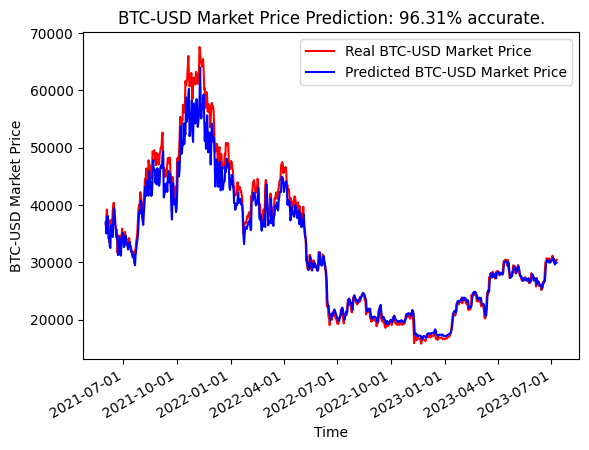

In [19]:
plt.plot(dates, real_price, color='red', label=f'Real {SYMBOL} Market Price')
plt.plot(dates, predicted_price, color='blue', label=f'Predicted {SYMBOL} Market Price')
plt.title(f"{SYMBOL} Market Price Prediction: {r2_score_value}% accurate.")
plt.xlabel('Time')
plt.ylabel(f'{SYMBOL} Market Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()